Концевая Владислава

## Partial-Image Neural Style Transformer
Реализован перенос двух стилей по заданной маске. Идея основана на [данной статье](http://cs231n.stanford.edu/reports/2017/pdfs/416.pdf).

In [ ]:
!pip3 uninstall torch torchvision
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [3]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [6]:
!ls sample_data/images/

anime-day-road.jpg  anime-night-road.jpg  anime-sunset-road.jpg


In [7]:
# image transformations
imsize = 512 

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

In [47]:
# image loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style1_img  = image_loader("sample_data/images/anime-sunset-road.jpg")   #change path if needed
style2_img  = image_loader("sample_data/images/anime-night-road.jpg")
content_img = image_loader("sample_data/images/anime-day-road.jpg")

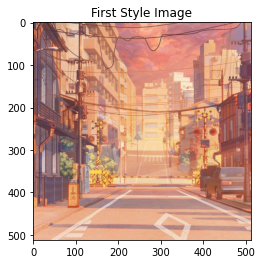

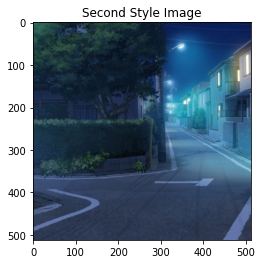

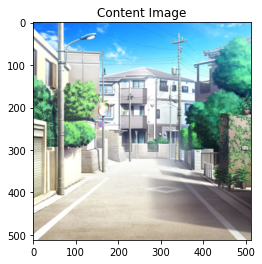

In [48]:
# image visualization
unloader = transforms.ToPILImage() 

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style1_img, title='First Style Image')

plt.figure()
imshow(style2_img, title='Second Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [11]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach() 
            self.loss = F.mse_loss(self.target, self.target )         # to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [12]:
def gram_matrix(input):
        batch_size, f_map_num, h, w = input.size()  # batch size(=1)
        # f_map_num=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * f_map_num, h * w)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())                  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

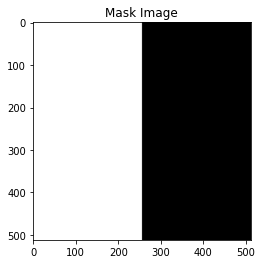

In [13]:
# mask example
first_half  = torch.ones([imsize, imsize // 2], dtype=torch.float64)  # part for style transfering
second_half = torch.zeros([imsize, imsize // 2], dtype=torch.float64)
mask = torch.cat((first_half, second_half), 1)
mask.unsqueeze_(0)
mask = torch.cat((mask, mask, mask), 0)

plt.figure()
imshow(mask, title='Mask Image')

In [49]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2):
            super(StyleLoss, self).__init__()
            self.target1 = gram_matrix(target_feature1).detach()
            self.target2 = gram_matrix(target_feature2).detach()
            self.loss = F.mse_loss(self.target1, self.target1) + F.mse_loss(self.target2, self.target2) # to initialize with something

        def forward(self, input):
            _, f_map_num, h, _ = input.size()                       # f_map_num = 64 (i.e.)
            mask = self.get_mask(h)
            mask = torch.stack(f_map_num * [mask[0]]).unsqueeze(0)  # to make mask of torch.Size([1, 64, 256, 256]) (i.e.)
            invert_mask = self.get_invert_mask(mask)                # inverted mask for transfering second style
                                                                    # to another part of the content image
            G = gram_matrix(mask * input)
            G_invert = gram_matrix(invert_mask * input)

            self.loss = F.mse_loss(G, self.target1) + F.mse_loss(G_invert, self.target2)  # sum up all the styles
            return input

        def get_mask(self, imsize=imsize):
            first_half  = torch.ones([imsize, imsize // 2]).to(device)
            second_half = torch.zeros([imsize, imsize // 2]).to(device)
            mask = torch.cat((first_half, second_half), 1).unsqueeze_(0)
            mask = torch.cat((mask, mask, mask), 0)
            return mask

        def get_invert_mask(self, mask):
            return (mask - 1) * (-1)

In [50]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [15]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [51]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [52]:
# we use pretrained model to extract features
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [18]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style1_img, style2_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target1_feature = model(style1_img).detach()
                target2_feature = model(style2_img).detach()
                style_loss = StyleLoss(target1_feature, target2_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [19]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [42]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style1_img, style2_img, input_img, num_steps=500,
                        style_weight=1000000, content_weight=10):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # considering weights
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

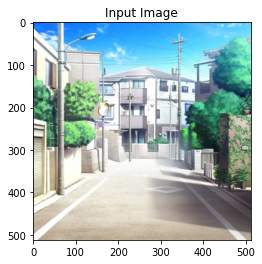

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 306.265656 Content Loss: 118.577995

run [100]:
Style Loss : 171.261307 Content Loss: 93.651848

run [150]:
Style Loss : 128.062317 Content Loss: 87.877441

run [200]:
Style Loss : 113.477898 Content Loss: 88.912964

run [250]:
Style Loss : 101.309067 Content Loss: 83.913391

run [300]:
Style Loss : 93.835449 Content Loss: 80.936623

run [350]:
Style Loss : 92.004074 Content Loss: 79.517395

run [400]:
Style Loss : 87.224297 Content Loss: 79.619919

run [450]:
Style Loss : 88.780273 Content Loss: 83.124123

run [500]:
Style Loss : 237.635315 Content Loss: 108.298706



In [53]:
# running
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, input_img)

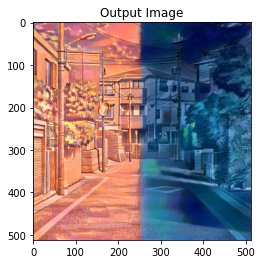

In [54]:
# result
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [40]:
# saving the result
from torchvision.utils import save_image

print(output[0].shape)
save_image(output[0], 'result-anime-night.png')

torch.Size([3, 512, 512])
